# Position based xT

# Setup

In [1]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import platform
from mplsoccer import Pitch
from scipy.stats import binned_statistic_2d

In [2]:
notebook_directory = os.getcwd()
course_directory = ""

if os.name == "posix": 
    course_directory = notebook_directory.rsplit("/Notebooks")[0]
else:
    course_directory = notebook_directory.rsplit("\\Notebooks")[0]
os.chdir(course_directory)

# Data

In [3]:
df = pd.DataFrame()

for i in range(13):
    with open(f"data/wyscout/events_England_{i+1}.json") as file:
        data = json.load(file)    
    df = pd.concat([df, pd.DataFrame(data)])

df

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175
...,...,...,...,...,...,...,...,...,...,...,...,...
43145,5,Ball out of the field,[],0,"[{'y': 32, 'x': 0}, {'y': 100, 'x': 100}]",2500098,Interruption,1623,2H,2796.732525,50,251596409
43146,3,Corner,"[{'id': 302}, {'id': 801}, {'id': 1801}]",70965,"[{'y': 100, 'x': 100}, {'y': 47, 'x': 88}]",2500098,Free Kick,1633,2H,2829.821084,30,251596232
43147,1,Air duel,"[{'id': 701}, {'id': 1802}]",7919,"[{'y': 53, 'x': 12}, {'y': 50, 'x': 14}]",2500098,Duel,1623,2H,2831.211419,10,251596410
43148,1,Air duel,"[{'id': 703}, {'id': 1801}]",8005,"[{'y': 47, 'x': 88}, {'y': 50, 'x': 86}]",2500098,Duel,1633,2H,2832.434399,10,251596234


# Calculate xT
## Step 1 to calculate xT : actions to move the ball.

In [4]:
next_event = df.shift(-1, fill_value=0)
df["next_event"] = next_event["subEventName"]
df["kickedOut"] = df.apply(lambda x: 1 if x["next_event"] == "Ball out of the field" else 0, axis=1)
move_df = df.loc[df["subEventName"].isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross'])]
pass_index = move_df[move_df["kickedOut"] == 1].index
move_df = move_df.drop(pass_index)
move_df["x"] = move_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
move_df["y"] = move_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
move_df["end_x"] = move_df.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
move_df["end_y"] = move_df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)
move_df_with_coords = move_df.loc[(((move_df["end_x"] != 0) & (move_df["end_y"] != 68)) & ((move_df["end_x"] != 105) & (move_df["end_y"] != 0)))]

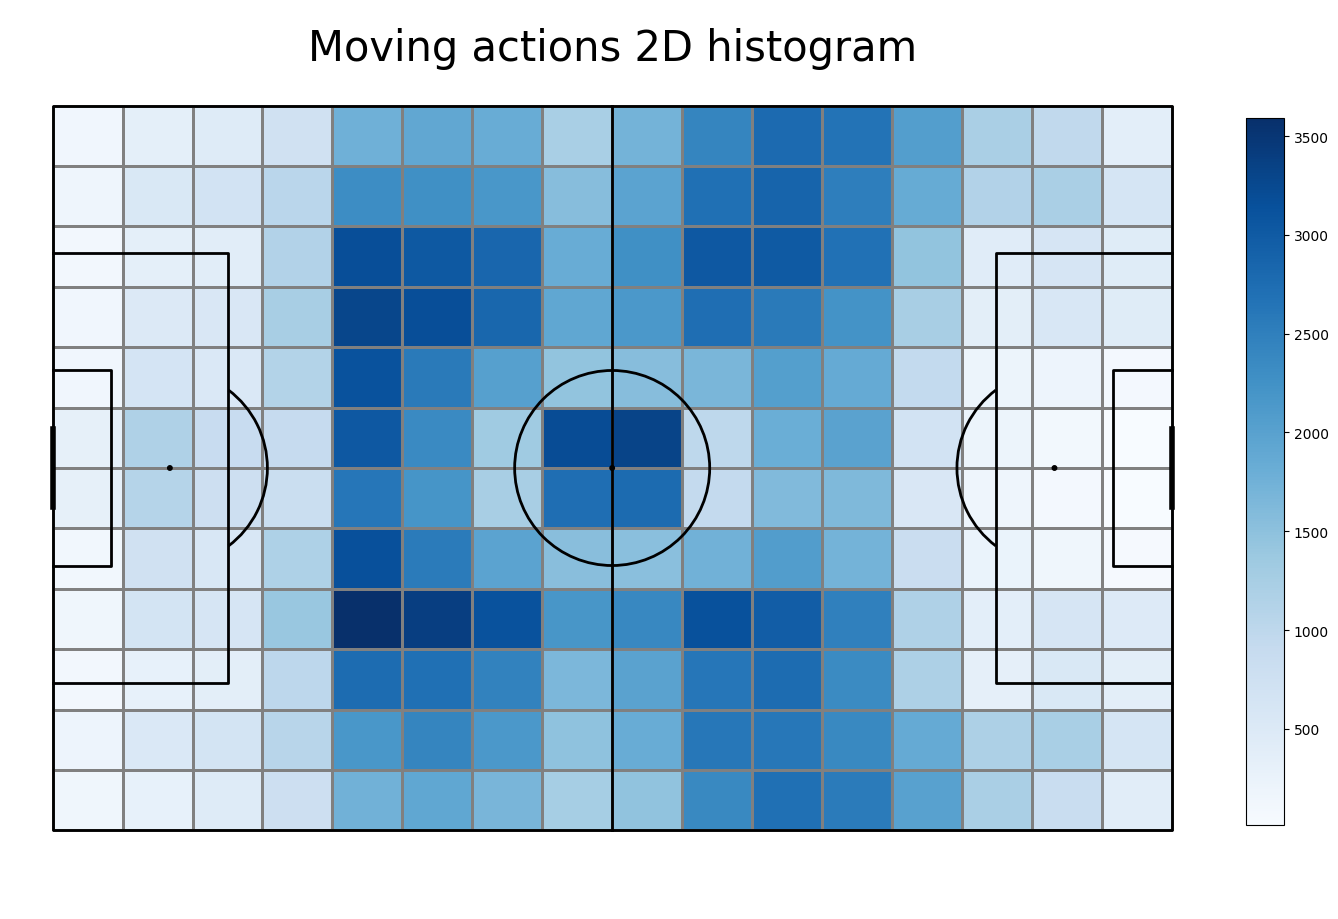

In [5]:
pitch = Pitch(line_color="black", pitch_type="custom", pitch_length=105, pitch_width=68, line_zorder=2)
move = pitch.bin_statistic(move_df["x"], move_df["y"], statistic="count", bins=(16,12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle("Moving actions 2D histogram", fontsize=30)
plt.show();

move_count = move["statistic"]

## Step 2 to calculate xT : Shots

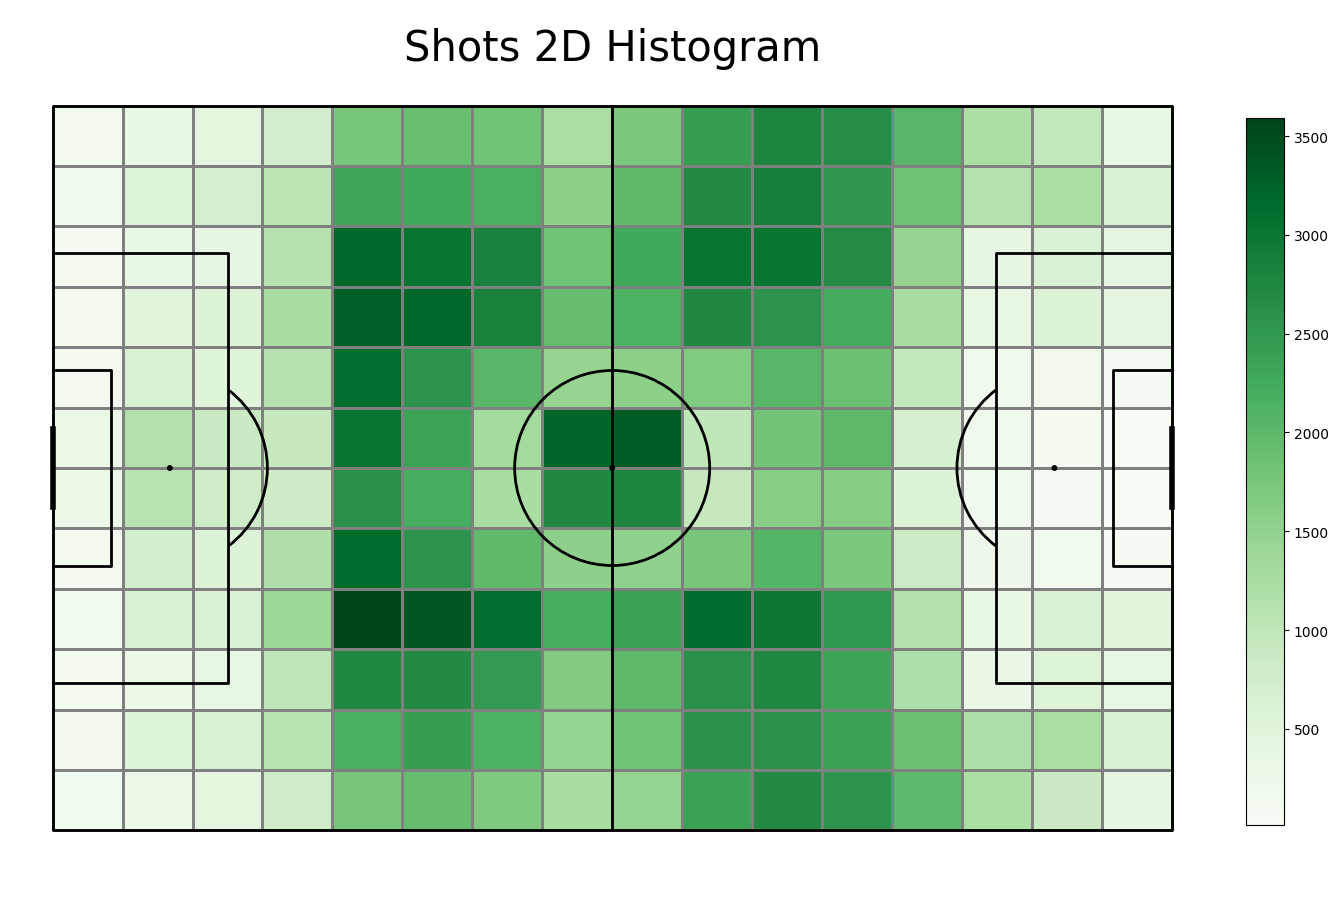

In [6]:
shot_df = df.loc[df["subEventName"] == "Shot"].copy()
shot_df["x"] = shot_df["positions"].apply(lambda cell: (cell[0]["x"]) * 105/100)
shot_df["y"] = shot_df["positions"].apply(lambda cell: (100 - cell[0]["y"]) * 68/100)

shot = pitch.bin_statistic(shot_df["x"], shot_df["y"], statistic="count", bins=(16,12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(move, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle("Shots 2D Histogram", fontsize=30)
plt.show();

shot_count = shot["statistic"]

## Step 3 to calculate xT: Goals

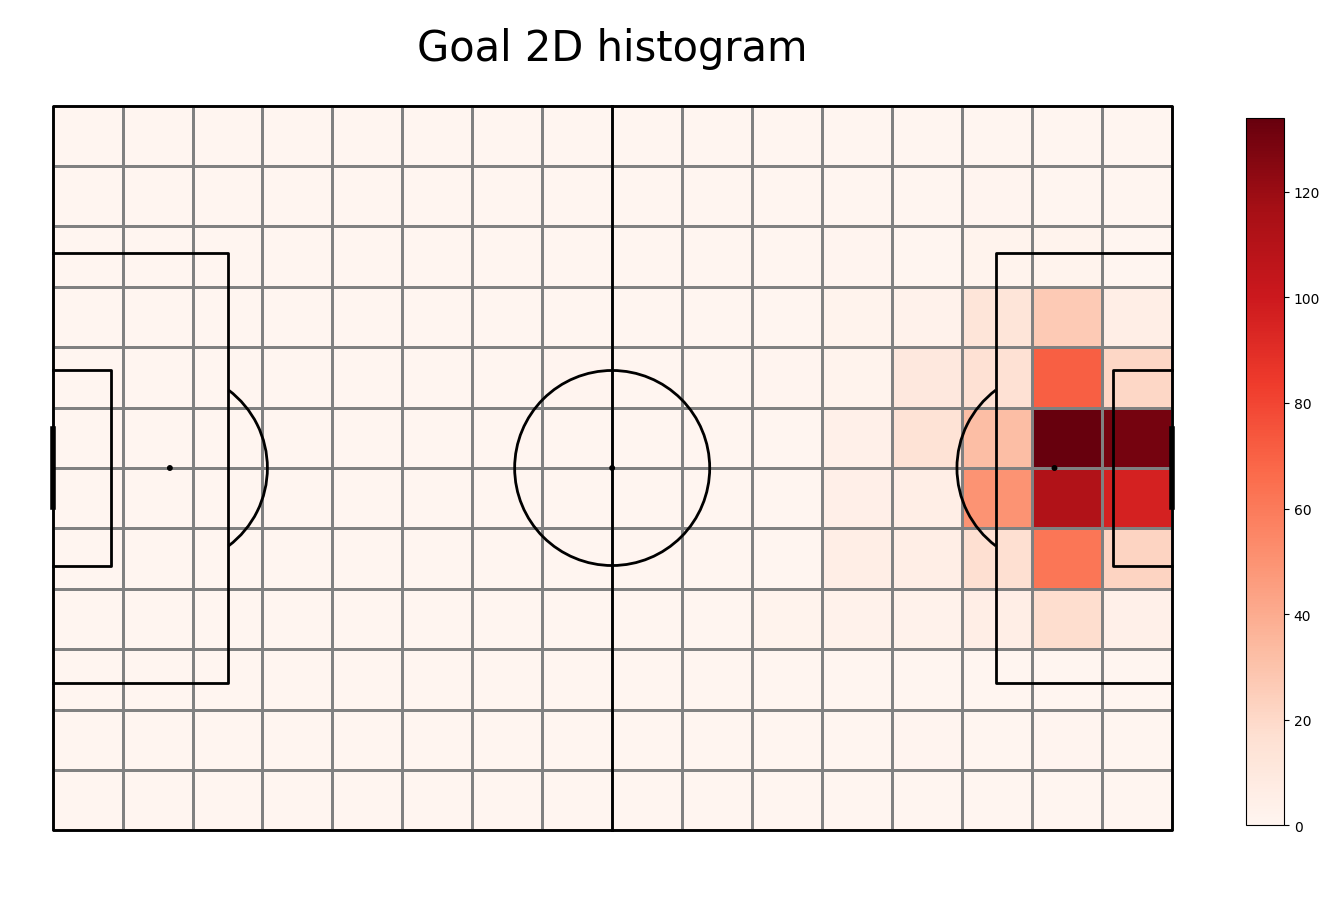

In [7]:
goal_df  = shot_df.loc[shot_df.apply(lambda x: {'id':101} in x.tags, axis = 1)]
goal = pitch.bin_statistic(goal_df.x, goal_df.y, statistic='count', bins=(16, 12), normalize=False)
goal_count = goal["statistic"]

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle('Goal 2D histogram', fontsize = 30)

plt.show();

## Step 4 to calculate xT : Move probability

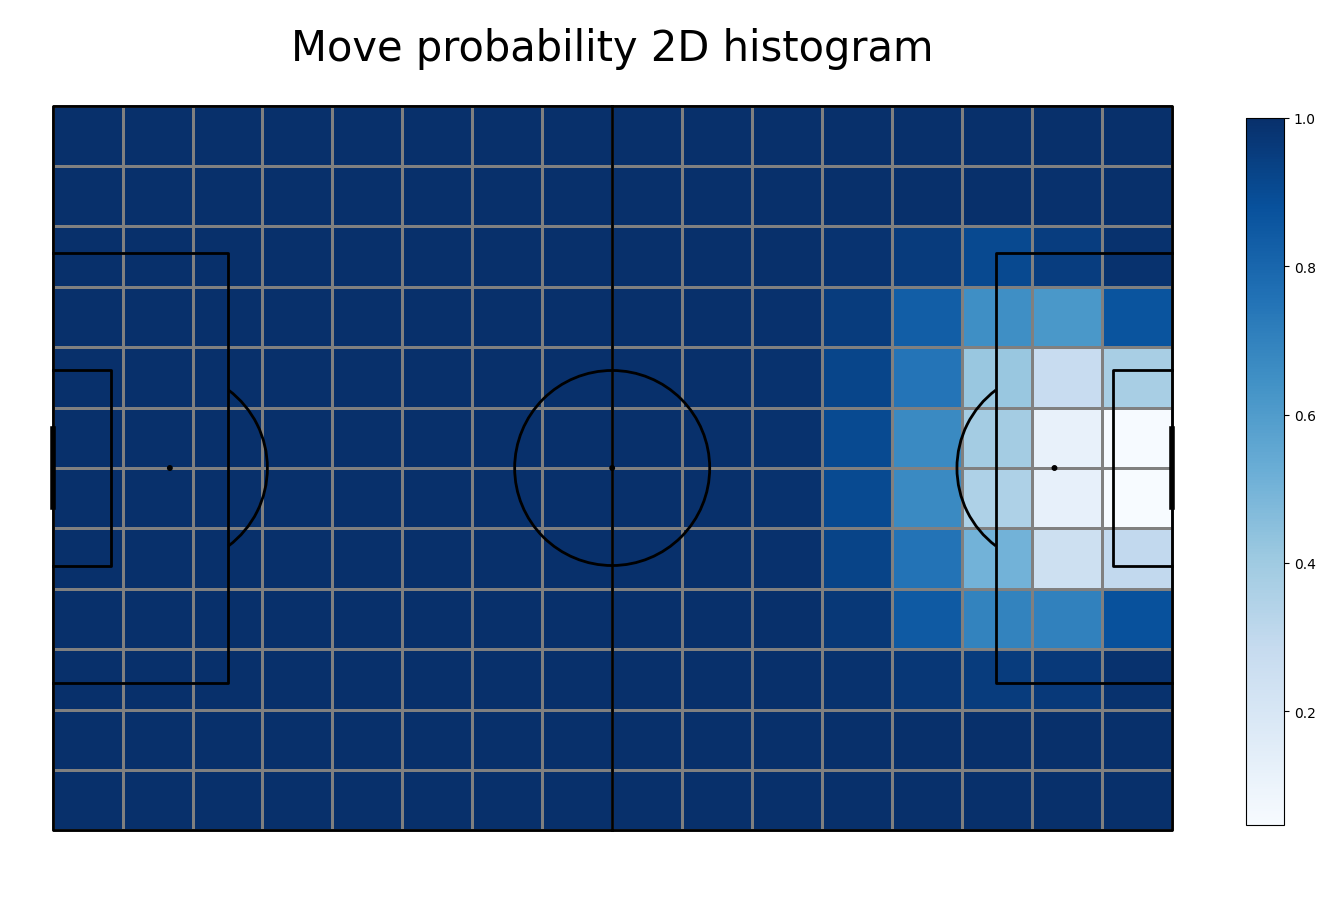

In [8]:
move_probability = move_count / (move_count +  shot_count)
move["statistic"] = move_probability

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm = pitch.heatmap(move, cmap="Blues", edgecolor="grey", ax=ax["pitch"])
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)  

fig.suptitle("Move probability 2D histogram", fontsize=30)
plt.show();

## Step 5 to calculate xT: Shot Probability

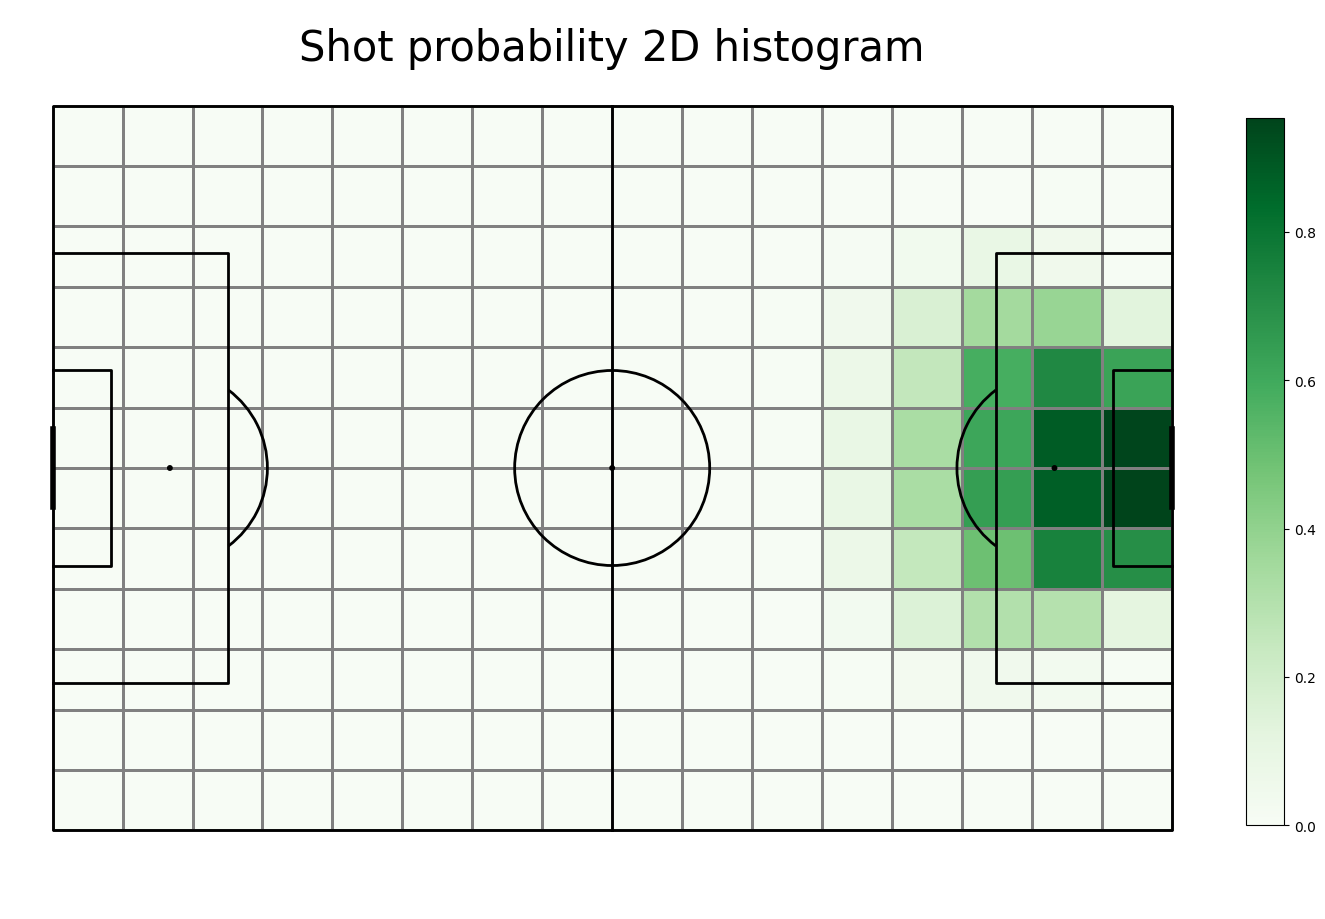

In [9]:
shot_probability = shot_count / (move_count +  shot_count)
shot["statistic"] = shot_probability

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm = pitch.heatmap(shot, cmap="Greens", edgecolor="grey", ax=ax["pitch"])
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)  

fig.suptitle("Shot probability 2D histogram", fontsize=30)
plt.show();

## Step 6 to calculate xT: Goal Probability
- Ideally xG would be used but, this will be a simplified model for now.

/var/folders/9d/gkyqvpm50h9dr1t_4gy_88l00000gn/T/ipykernel_35866/3425206482.py:1: RuntimeWarning: invalid value encountered in divide
  goal_probability = goal_count/shot_count


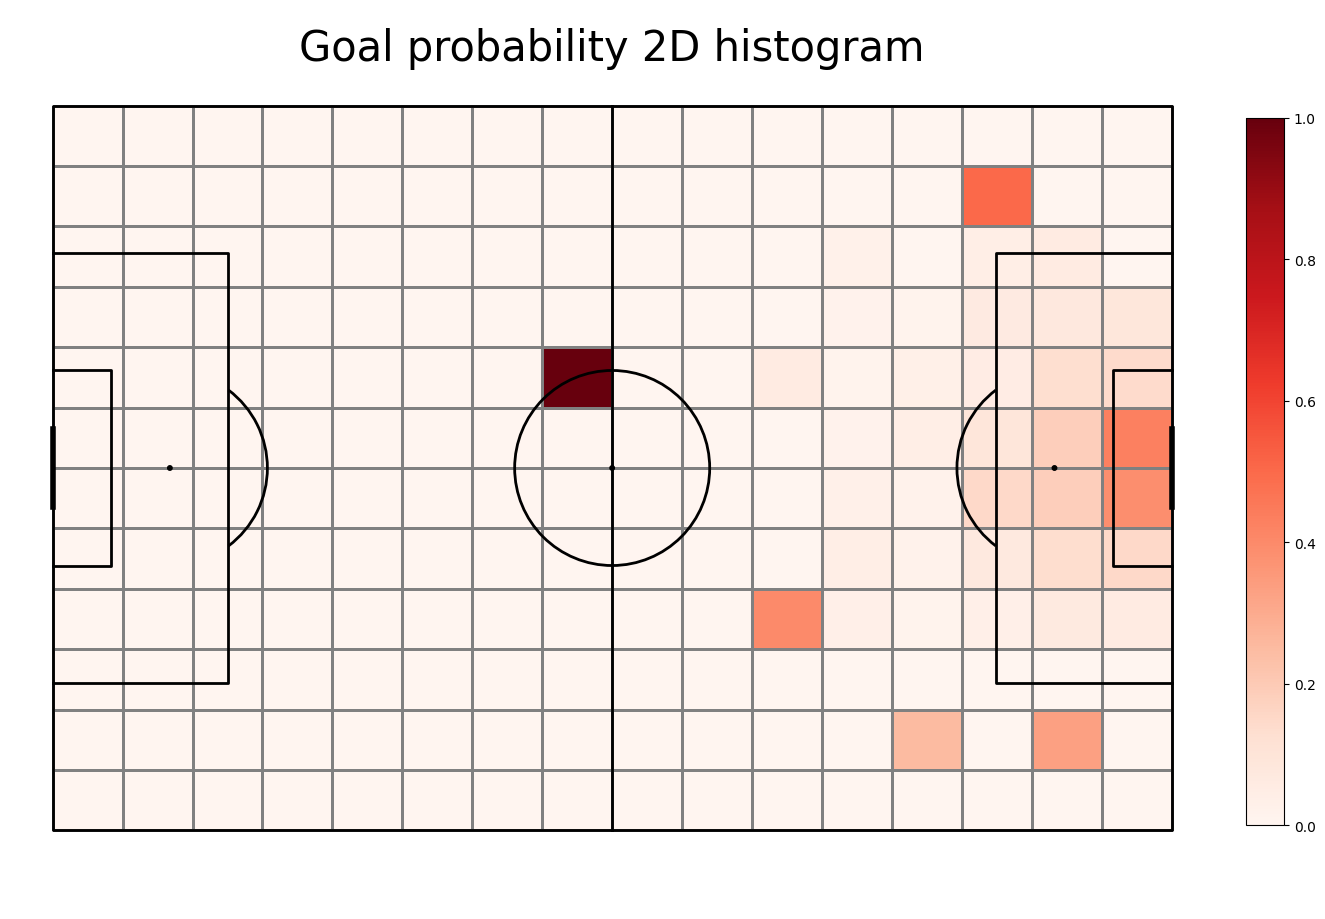

In [10]:
goal_probability = goal_count/shot_count
goal_probability[np.isnan(goal_probability)] = 0

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
goal["statistic"] = goal_probability

pcm = pitch.heatmap(goal, cmap="Reds", edgecolor="grey", ax=ax["pitch"])
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle("Goal probability 2D histogram", fontsize=30)
plt.show();

## Step 7 to calculate xT: Transition Matrices
- For each of the 192 squares (16*12), we need to calculate a transition matrix. This will tell us the probability of going from one zone to another.

In [11]:
move_df["start_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row["x"]), np.ravel(row["y"]),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)

move_df["end_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row["end_x"]), np.ravel(row["end_y"]),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)

In [12]:
df_count_starts = move_df.groupby(["start_sector"])["eventId"].count().reset_index()
df_count_starts.rename(columns={"eventId":"count_starts"}, inplace=True)

In [13]:
transition_matrices = []
for i, row in df_count_starts.iterrows():
    start_sector = row["start_sector"]
    count_starts = row["count_starts"]

    this_sector = move_df.loc[move_df["start_sector"] == start_sector]
    df_count_ends = this_sector.groupby(["end_sector"])["eventId"].count().reset_index()
    df_count_ends.rename(columns = {"eventId":"count_ends"}, inplace=True)
    T_matrix = np.zeros((12,16))

    for j, row2 in df_count_ends.iterrows():
        end_sector = row2["end_sector"]
        value = row2["count_ends"]
        T_matrix[end_sector[1] - 1][end_sector[0] - 1] = value
    
    T_matrix = T_matrix / count_starts
    transition_matrices.append(T_matrix)

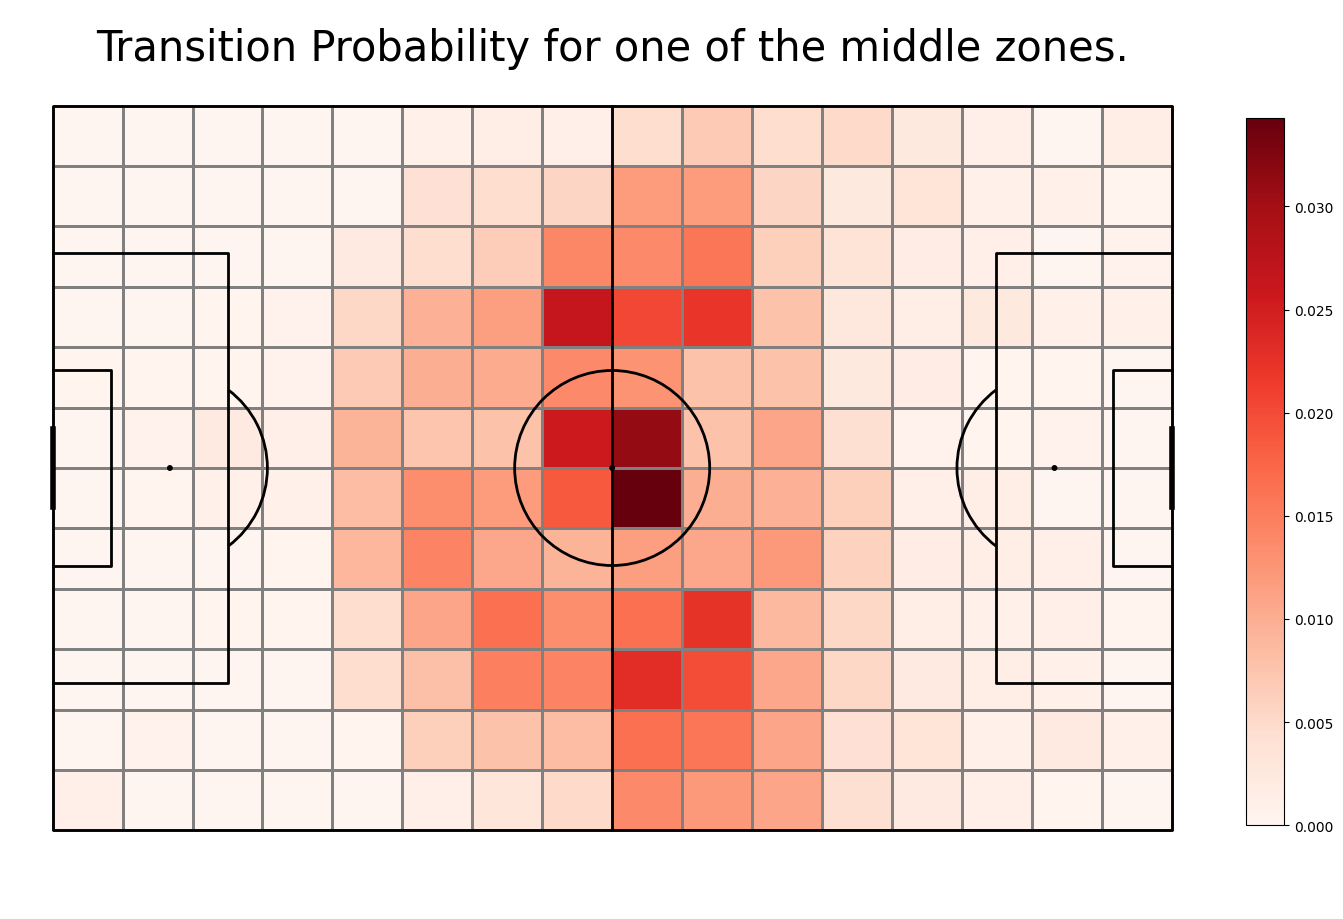

In [14]:
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
goal["statistic"] = transition_matrices[90]
pcm = pitch.heatmap(goal, cmap="Reds", edgecolor="Grey", ax=ax["pitch"])
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle("Transition Probability for one of the middle zones.", fontsize=30)
plt.show();

# Calculating the Expected Threat Matrix
Steps:
1) $P(S) * P(G|S)$ : Probability of a shot * probability of a goal given a shot = Shoot Expected Payoff
2) $P(G|P) :$ Probability of a goal if a player passes the ball = Move Expected Payoff

$\text{Shoot Expected Payoff} + \text{Move Expected Payoff}$


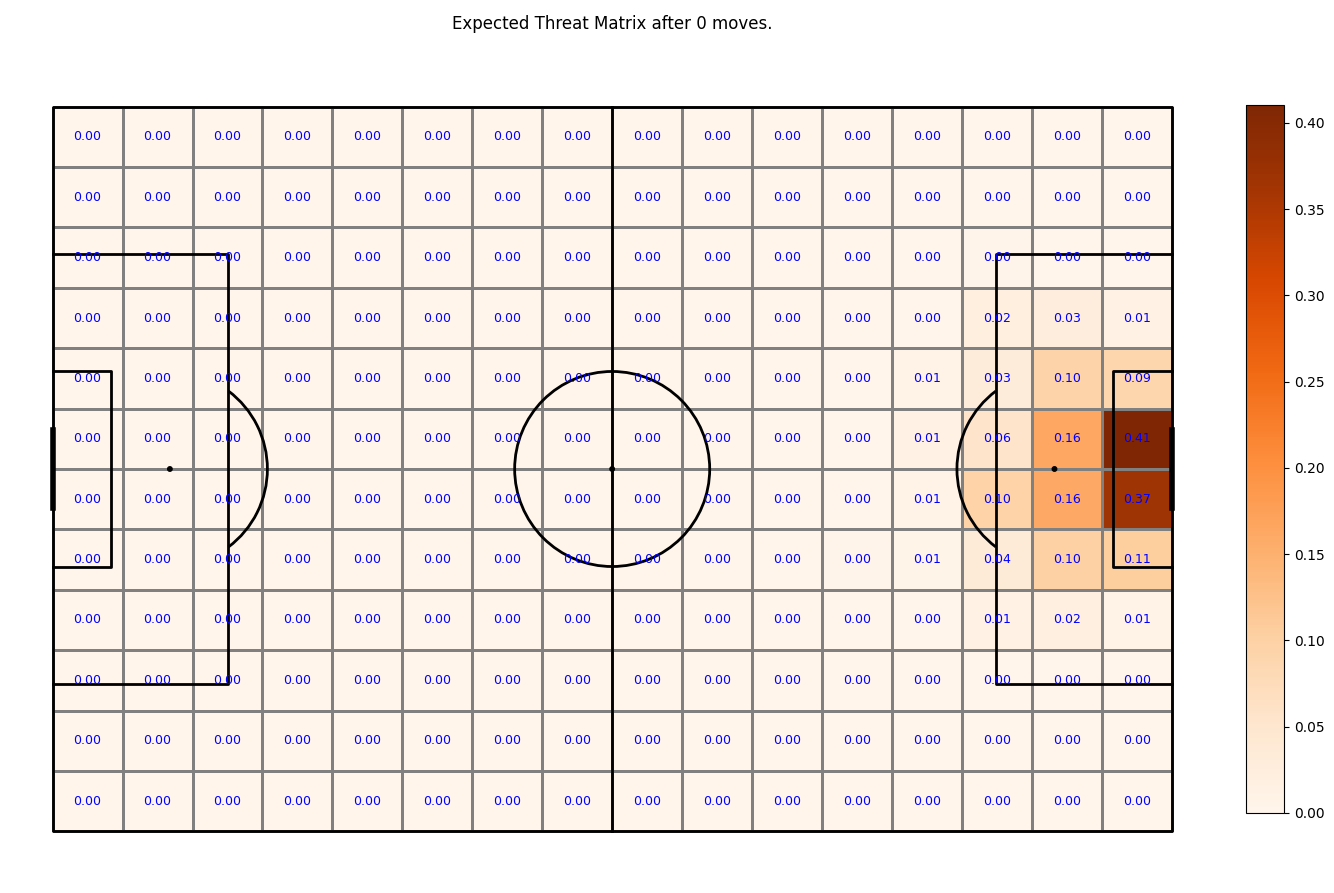

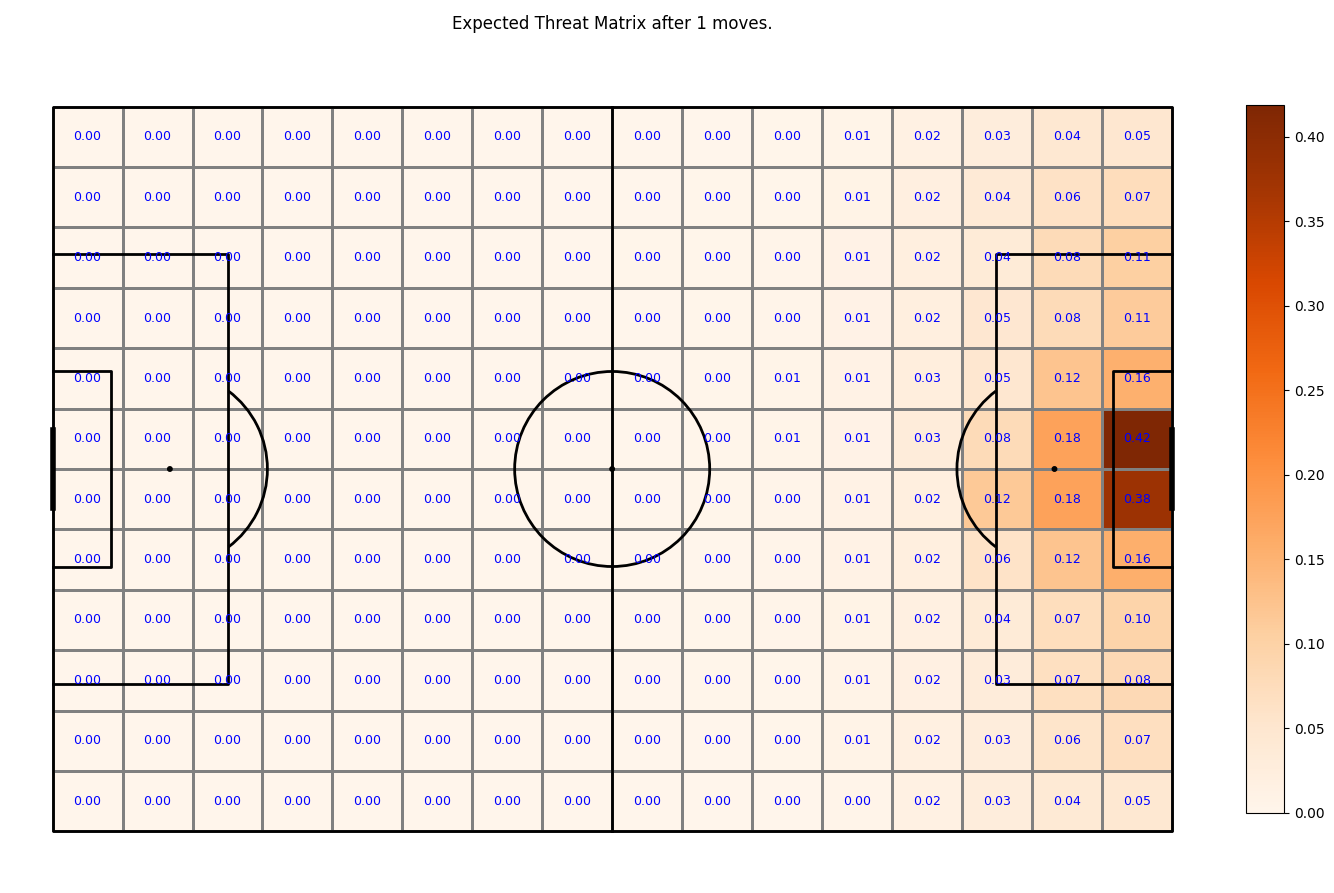

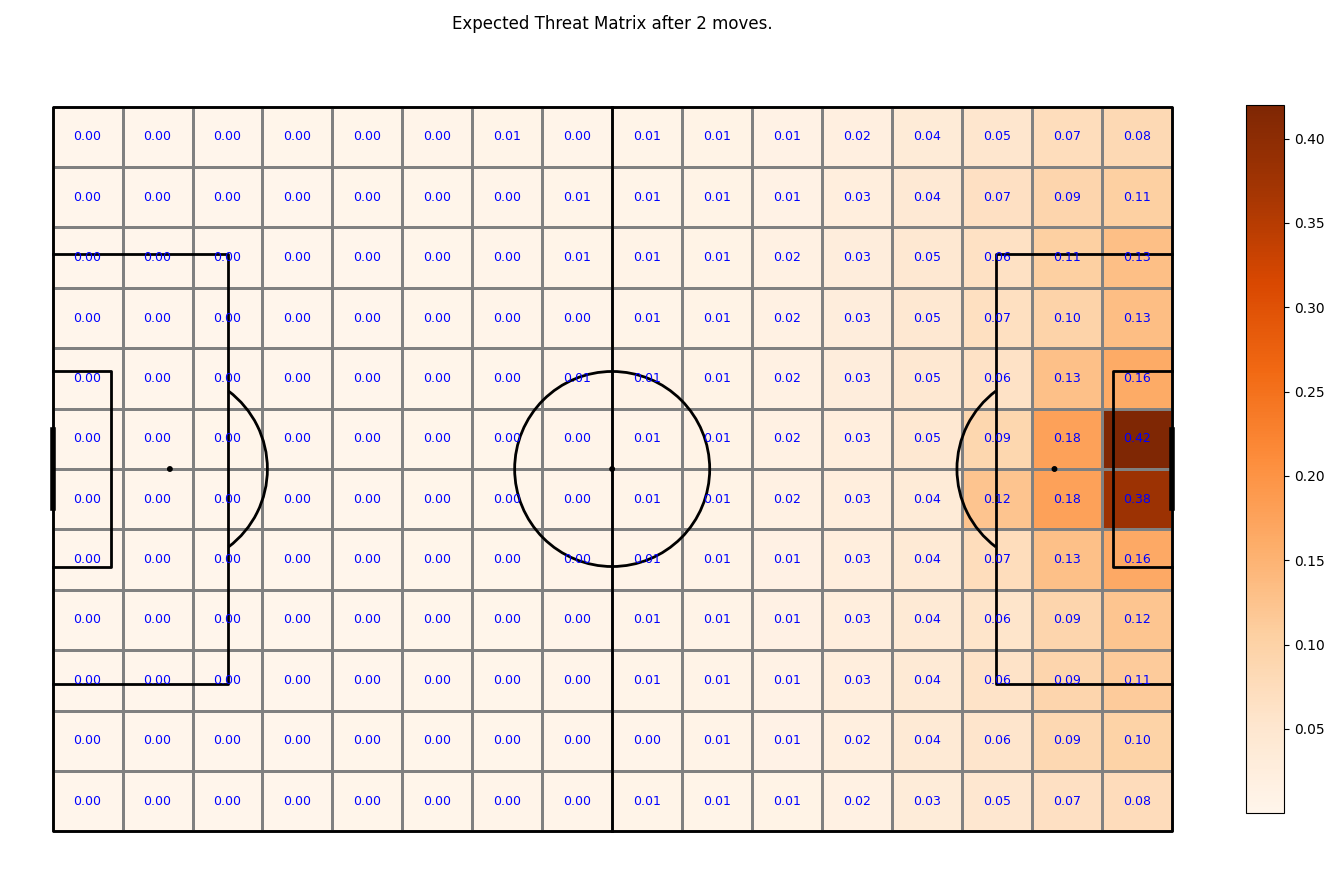

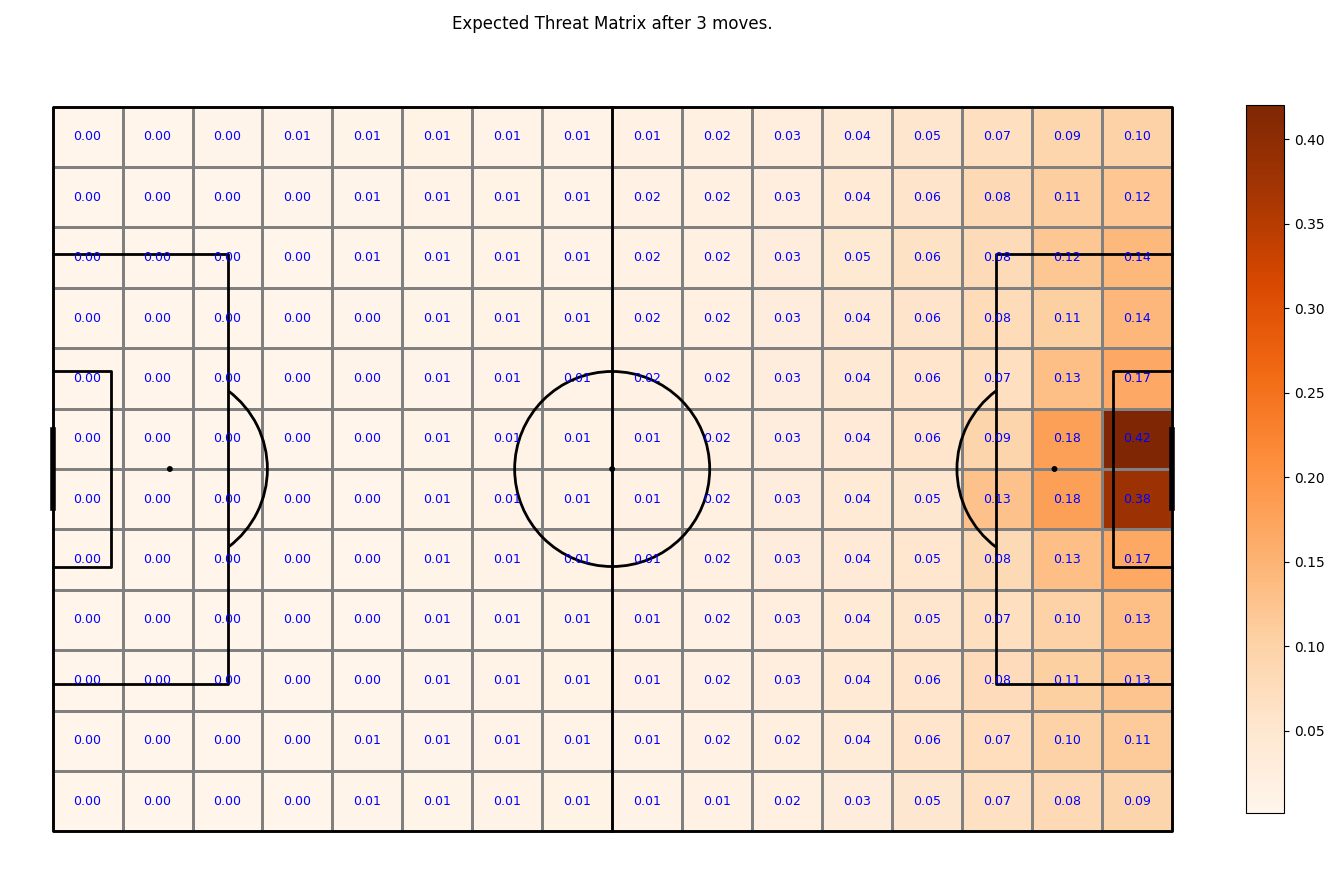

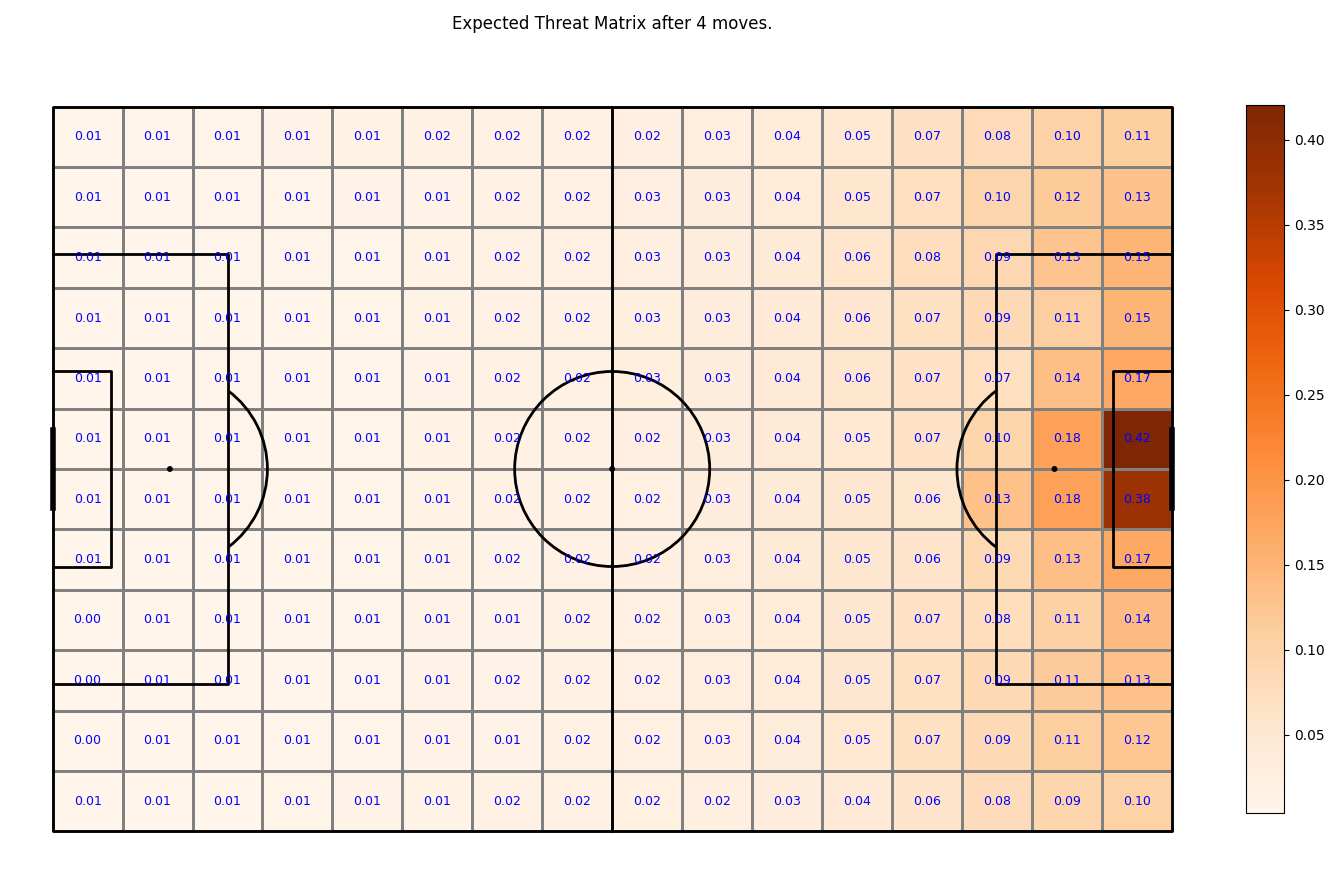

In [15]:
transition_matrices_array = np.array(transition_matrices)
xT = np.zeros((12,16))

for i in range(5):
    shoot_expected_payoff = goal_probability * shot_probability
    move_expected_payoff = move_probability * (np.sum(np.sum(transition_matrices * xT, axis = 2), axis=1).reshape(16,12).T)
    xT = shoot_expected_payoff + move_expected_payoff

    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.01, title_space=0, endnote_space=0)
    goal["statistic"] = xT
    pcm = pitch.heatmap(goal, cmap="Oranges", edgecolor="grey", ax=ax["pitch"])
    labels = pitch.label_heatmap(goal, color="Blue", fontsize=9, ax=ax["pitch"], ha="center", va="center", str_format="{0:,.2f}", zorder=3)
    
    ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
    cbar = plt.colorbar(pcm, cax=ax_cbar)
    fig.suptitle(f"Expected Threat Matrix after {i} moves.")
    plt.show();

## Applying xT to moving actions

In [16]:
only_successful_moves = move_df.loc[move_df.apply(lambda x: {'id':1801} in x.tags, axis=1)].copy()
only_successful_moves["xT_added"] = only_successful_moves.apply(lambda row: xT[row.end_sector[1] - 1][row.end_sector[0] - 1] - xT[row.start_sector[1] - 1][row.start_sector[0] - 1], axis=1)
value_adding_actions = only_successful_moves.loc[only_successful_moves["xT_added"] > 0]

# Players with the highest xT
- Now the most important part, which players actually have the highest xT?

In [96]:
xT_by_player = value_adding_actions.groupby("playerId")["xT_added"].sum().reset_index()
player_df = pd.read_json("data/wyscout/players.json", encoding="unicode_escape")
player_df.rename(columns={"wyId" : "playerId"}, inplace=True)
player_df["role"] = player_df.apply(lambda x: x.role["name"], axis=1)
to_merge = player_df[["playerId", "shortName", "role"]]
summary = xT_by_player.merge(to_merge, how="left", on="playerId")
summary

,playerId,xT_added,shortName,role
0,36,8.295529,T. Alderweireld,Defender
1,38,1.954002,D. Blind,Defender
2,48,16.200525,J. Vertonghen,Defender
3,54,21.605365,C. Eriksen,Midfielder
4,56,0.776770,D. Klaassen,Midfielder
...,...,...,...,...
501,447812,1.110861,T. Edwards,Defender
502,448708,0.078669,H. Barnes,Midfielder
503,450826,0.120135,C. Hudson-Odoi,Midfielder
504,486252,1.868277,A. Wan-Bissaka,Defender


In [98]:
minutes_played_per_game_df = pd.read_json("data/wyscout/minutes_played_per_game_England.json")
minutes_per_player = minutes_played_per_game_df.groupby("playerId")["minutesPlayed"].sum().reset_index()
summary_with_minutes = minutes_per_player.merge(summary, how="left", on="playerId")
summary_with_minutes = summary_with_minutes.fillna(0)
summary_with_minutes_greater_than_400 = summary_with_minutes.loc[summary_with_minutes["minutesPlayed"] > 400].copy()
summary_with_minutes_greater_than_400["xT_per_90"] = summary_with_minutes_greater_than_400["xT_added"] * 90 / summary_with_minutes_greater_than_400["minutesPlayed"].copy()

In [99]:
possesion_percentage_df = pd.read_json("data/wyscout/player_possesion_England.json")
possesion_percentage_df

,playerId,possesion
0,9206,0.446999
1,9127,0.439018
2,93,0.438288
3,9179,0.471322
4,10108,0.433335
...,...,...
510,297258,0.305936
511,227756,0.699029
512,20450,0.380787
513,447254,0.364312


In [100]:
summary_400_mins_and_possesion = summary_with_minutes_greater_than_400.merge(possesion_percentage_df, how="left", on="playerId")
summary_400_mins_and_possesion["xT_adjusted_per_90"] = (summary_400_mins_and_possesion["xT_added"] / summary_400_mins_and_possesion["possesion"]) * 90 / summary_400_mins_and_possesion["minutesPlayed"]
summary_400_mins_and_possesion = summary_400_mins_and_possesion.sort_values("xT_adjusted_per_90", ascending=False)
summary_400_mins_and_possesion

,playerId,minutesPlayed,xT_added,shortName,role,xT_per_90,possesion,xT_adjusted_per_90
27,3350,2408,23.616619,Fàbregas,Midfielder,0.882681,0.548264,1.609956
271,38021,3190,31.700888,K. De Bruyne,Midfielder,0.894382,0.689888,1.296418
22,3319,2253,19.292954,M. Özil,Midfielder,0.770691,0.603388,1.277273
78,7967,2366,14.485167,J. Shelvey,Midfielder,0.551000,0.432626,1.273618
68,7936,2233,17.666814,P. Pogba,Midfielder,0.712053,0.568005,1.253603
...,...,...,...,...,...,...,...,...
283,61941,1888,0.457908,F. Forster,Goalkeeper,0.021828,0.523969,0.041659
146,8580,1699,0.342425,A. McCarthy,Goalkeeper,0.018139,0.492624,0.036821
157,8726,3612,0.703389,A. Begović,Goalkeeper,0.017526,0.478365,0.036638
130,8425,2531,0.455074,W. Hennessey,Goalkeeper,0.016182,0.453535,0.035680


In [101]:
summary_400_mins_and_possesion[["shortName", "xT_adjusted_per_90"]].head(5)

,shortName,xT_adjusted_per_90
27,Fàbregas,1.609956
271,K. De Bruyne,1.296418
22,M. Özil,1.277273
78,J. Shelvey,1.273618
68,P. Pogba,1.253603


# Challenges
1) xT calc as for loops to enhance understanding.
2)  Include unsuccesful and non-progressive actions by assigning -xT.

## Challenge 1 - xT calc as for loops to enhance understanding.